필요한 라이브러리 호출

In [1]:
import bok_da as bd
import os
import requests
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy import kron, eye, diag, reshape
from scipy.linalg import eig

# <font color='k'>79개 저축은행 대손상각비 시계열 데이터 생성 </font>
- FAIRS, FISS 데이터를 이용한 저축은행 대손상각비 시계열 전처리
- 작성자: 금융안정국 시스템리스크팀 오세연 과장

## 0. 시계열 날짜 및 저축은행 id 설정

In [3]:
# 조회 시계열(YYYY-MM-DD 형태로 입력)
start_date = "2015-12-01"  # 2023년말 data까진 csv 파일을 loading. 일부 data만 update해도 됨(날짜 수정 가능)
end_date = "2024-06-30"  # 작업 월

# True: YYYY-MM, False: YYYY-MM-DD
period_trim = True
svbank_id = ['0010345', '0010346', '0010349', '0010350', '0010354', '0010358', '0010359', '0010363', '0010366', '0010370', 
             '0010378', '0010388', '0010389', '0010390', '0010391', '0010404', '0010416', '0010418', '0010419', '0010421', 
             '0010426', '0010430', '0010437', '0010438', '0010439', '0010448', '0010449', '0010453', '0010456', '0010457', 
             '0010460', '0010463', '0010464', '0010467', '0010468', '0010471', '0010473', '0010477', '0010478', '0010485', 
             '0010488', '0010489', '0010492', '0010508', '0010509', '0010510', '0010521', '0010526', '0010527', '0010528', 
             '0010533', '0010534', '0010537', '0010550', '0010551', '0010553', '0010556', '0010560', '0010562', '0010568', 
             '0010569', '0010572', '0010574', '0010575', '0010576', '0011551', '0011767', '0012120', '0012711', '0012840', 
             '0012889', '0013002', '0013127', '0013166', '0013308', '0013313', '0013351', '0013350']

## 1. 데이터 불러오기

- FAIRS, FISS 시계열 자료는 접근권한이 있어야 하며, api를 통해 입수할때 마다 변경된 bidas_stoken값을 입력해야 한다.
- bidas_stoken 값은 BIDAS 접속 후, `메인화면에서 우클릭` -> `제일 아래 '검사' 클릭` -> `응용프로그램` -> `쿠키` -> `http://bidas.boknet.intra 클릭`해서 보이는 `sToken` 값으로 지정하면 된다.

In [ ]:
bidas_stoken = 'Vy3zFySFx5FASzTyGIDx5FDEMO1zCy1728522016zPy86400zAy34zEyOtHXx79wLk8H9jvjJx2B5QRZeZx2FaoQZKx2BPdNvifer9X6D8YUjOmP1x79Jx7AcMnvY5LDNnBx78pfYo2bkFx79i7EbiRBx7Afx2FoVcPuKC3x7AGWTib434TPx7ACax7Asx3DzKyDIhVBbdux2BDS94Vx78tW0ud2Gx2FoO4t4GAjdPvx78JsStx78fTIx3DzSSy00000703060zUURy9c8964bfc38677bfzMyx7ATMVoElx786Gox3Dz'

In [4]:
req_id = []
alias_nm = []

for inst_id in svbank_id:
    req_id.append(f'FAIRS-AE011-{inst_id}-C50010071-A-1-6')
    alias_nm.append(f'대손상각비_{inst_id}')

#푸른상호
req_id.append('FISS-AE063-0010356-C50010071-F-KRW-M')
alias_nm.append('대손상각비_0010356')

df_temp = bd.get_fairsfiss_data(req_id, alias_nm, bidas_stoken, start_date, end_date, period_trim)
df_temp = pd.wide_to_long(df_temp.reset_index(), stubnames='대손상각비', i='period', j='inst_id', sep='_')
df_temp.reset_index(inplace=True)
df_temp.head(10)

,period,inst_id,대손상각비
0,2016-03,10345,16623.0
1,2016-04,10345,23251.0
2,2016-05,10345,28772.0
3,2016-06,10345,34858.0
4,2016-07,10345,42352.0
5,2016-08,10345,49589.0
6,2016-09,10345,53947.0
7,2016-10,10345,61553.0
8,2016-11,10345,69299.0
9,2016-12,10345,107487.0


## 2. 분기별 자료로 변환

In [5]:
df_temp['month'] = df_temp['period'].dt.month
df_temp = df_temp.loc[df_temp['month'] % 3 == 0]
df_temp

,period,inst_id,대손상각비,month
0,2016-03,10345,16623.0,3
3,2016-06,10345,34858.0,6
6,2016-09,10345,53947.0,9
9,2016-12,10345,107487.0,12
12,2017-03,10345,17138.0,3
...,...,...,...,...
7887,2023-06,10356,2369.0,6
7890,2023-09,10356,8030.0,9
7893,2023-12,10356,18716.0,12
7896,2024-03,10356,10307.0,3


In [6]:
from bok_da import FairsFissPreprocessing as FFP

# calendar year to date -> qoq
df_temp = FFP.lag_1q(df_temp, 'inst_id', 'period', '대손상각비')
df_temp['대손상각비_qoq'] = df_temp['대손상각비']
df_temp.loc[df_temp['month']!=3, '대손상각비_qoq'] = df_temp['대손상각비'] - df_temp['대손상각비_L1']
df_temp.head(50)

# keep qoqs and rename
df_llp = df_temp.filter(regex='period|inst_id|_qoq$')
df_llp = df_llp.drop(columns=['inst_id_L1'])
df_llp.columns = df_llp.columns.str.replace('_qoq', '', regex=False)
df_llp

,period,inst_id,대손상각비
0,2016-03,10345,16623.0
3,2016-06,10345,18235.0
6,2016-09,10345,19089.0
9,2016-12,10345,53540.0
12,2017-03,10345,17138.0
...,...,...,...
7687,2023-06,13351,53242.0
7690,2023-09,13351,50028.0
7693,2023-12,13351,63184.0
7696,2024-03,13351,162711.0


In [ ]:
df_llp.to_csv("df_llp.csv", index=False, encoding='utf-8-sig')

# 3. 데이터 요약 정보

In [7]:
df_llp.groupby('period')['대손상각비'].count().describe()  #mean=79, std=0

count    34.0
mean     79.0
std       0.0
min      79.0
25%      79.0
50%      79.0
75%      79.0
max      79.0
Name: 대손상각비, dtype: float64

In [8]:
df_plt=pd.DataFrame(df_llp.groupby('period')['대손상각비'].sum())
df_plt.reset_index(inplace=True)
df_plt.head(5)

,period,대손상각비
0,2016-03,203779.0
1,2016-06,228708.0
2,2016-09,196259.0
3,2016-12,292981.0
4,2017-03,269974.0


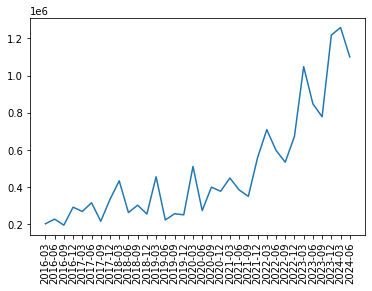

In [9]:
plt.figure()
plt.plot(df_plt['period'].astype(str), df_plt['대손상각비'])
plt.xticks(rotation=90)
plt.show()

In [10]:
df_llp

,period,inst_id,대손상각비
0,2016-03,10345,16623.0
3,2016-06,10345,18235.0
6,2016-09,10345,19089.0
9,2016-12,10345,53540.0
12,2017-03,10345,17138.0
...,...,...,...
7687,2023-06,13351,53242.0
7690,2023-09,13351,50028.0
7693,2023-12,13351,63184.0
7696,2024-03,13351,162711.0
